## LAB: **ATTENTION IN COMPUTER VISION**

---

***STUDENT(S):*** 

---

In the context of machine learning, **attention** is a technique that mimics cognitive attention, defined as the ability to choose and concentrate on relevant stimuli. In other words, **attention is a method that tries to enhance the important parts while fading out the non-relevant information**. The idea of Attention Mechanisms was first popularly introduced in the domain of Natural Language Processing (NLP) in the NeurIPS 2017 paper by Google Brain, titled ["**Attention Is All You Need**"](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

In computer vision, attention has found its way into several applications, such as in the domains of image classification, image segmentation, and image captioning.

<figure>
<center><img src="https://miro.medium.com/max/1400/1*sRy3ukQziKP0TSQqlz3LCg.webp" width="80%"></center> 
<figcaption align = "center"> Attention maps in an image captioning problem. </figcaption>
</figure>

# **CBAM**: Convolutional Block Attention Module 

In this lab we are going to implement one of the most popular attention modules in computer vision: the **Convolutional Block Attention Module (CBAM)**. It contains two sequential sub-modules called the **Channel Attention Module (CAM)** and the **Spatial Attention Module (SAM)**, which are applied in that particular order. The authors of the [paper](https://openaccess.thecvf.com/content_ECCV_2018/papers/Sanghyun_Woo_Convolutional_Block_Attention_ECCV_2018_paper.pdf) point out that CBAM is applied at every convolutional block in deep networks to get subsequent "*Refined Feature Maps*" from the "*Input Intermediate Feature Maps*". 

Before going through the specifics and implementation of Spatial and Channel Attention respectively, let's get to know what these terms mean and why they are essential.

*   ***Spatial*** refers to the domain space encapsulated within each **feature map**. Spatial attention represents the attention mechanism/attention mask on the feature map, or a single cross-sectional slice of the tensor. Refining the feature maps using Spatial Attention, we are **enhancing the input to the subsequent convolutional layers** which thus improves the performance of the model.
*   ***Channel*** attention essentially provides a weight for each channel and thus **enhances those particular channels which are most contributing towards learning** and thus boosts the overall model performance.

# Dataset

In this lab we are going yo apply CBAM in a classification problem. For that, we have selected the [STL-10 dataset](https://cs.stanford.edu/~acoates/stl10/), including a white patch to some images (as displayed below). The task is to create a neural network that classifies both types of images.

<figure>
<center><img src="https://miro.medium.com/max/1018/1*rzmgXEF2VJbw6IAB2bA-Cw.webp" width="55%"></center> 
<figcaption align = "center"> STL images. Those images labeled as 1 belong to the class whose images have a white patch while those labeled as 0 are the ones that do not have the white patch.</figcaption>
</figure>

# Imports

In [1]:
import os
from PIL import Image
import torchvision
from torchvision.datasets import STL10
from torchvision import datasets, transforms, utils
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!


# PART I: Loading and preprocessing STL-10 dataset

Download the STL-10 dataset using torchvision.



In [2]:
# Original dataset
data_train = STL10("stl10_train", split='train', download=True)
data_test = STL10("stl10_test", split='test', download=True)

Files already downloaded and verified
Files already downloaded and verified


Now we define a dataset class to define the corrupted version of the images and their labels. It takes as input the images from the original dataset.

In [3]:
class STL10_patch(Dataset):

  def __init__(self, dataset_og):

    self.dataset_og = dataset_og

  def __len__(self):
    return len(self.dataset_og)
  
  def __getitem__(self, index):

    image = self.dataset_og.__getitem__(index)[0]

    # Split in image and labels
    stl_image, label = self.corrupt_patch(image)
    
    # Transform image
    stl_image = self.transform_img(Image.fromarray(stl_image))

    return stl_image, label

  def corrupt_patch(self, img):

    img = np.array(img)

    corrupt = np.random.randint(2)

    label = 0.

    if corrupt:
      # Set label to 1 and add the patch
      label = 1.
      pos_x = np.random.randint(96-16)
      pos_y = np.random.randint(96-16)
      img[pos_x:pos_x+16, pos_y:pos_y+16, :] = 1

    return img, torch.tensor(label)

  
  def transform_img(self, image):

    transform_ops = torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    return transform_ops(image)


Let's show an example from our *corrupted* dataset. We define a method to visualize the images, as they are normalized.

In [4]:
def img_show(img):
    img = img / 2 + 0.5     # unnormalize to plot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
# 'Corrupted' dataset
trainset = STL10_patch(data_train)
testset = STL10_patch(data_test)

print('Trainset: ', len(trainset))
print('Testset: ', len(testset))

Trainset:  5000
Testset:  8000


IMG shape:  torch.Size([3, 96, 96])


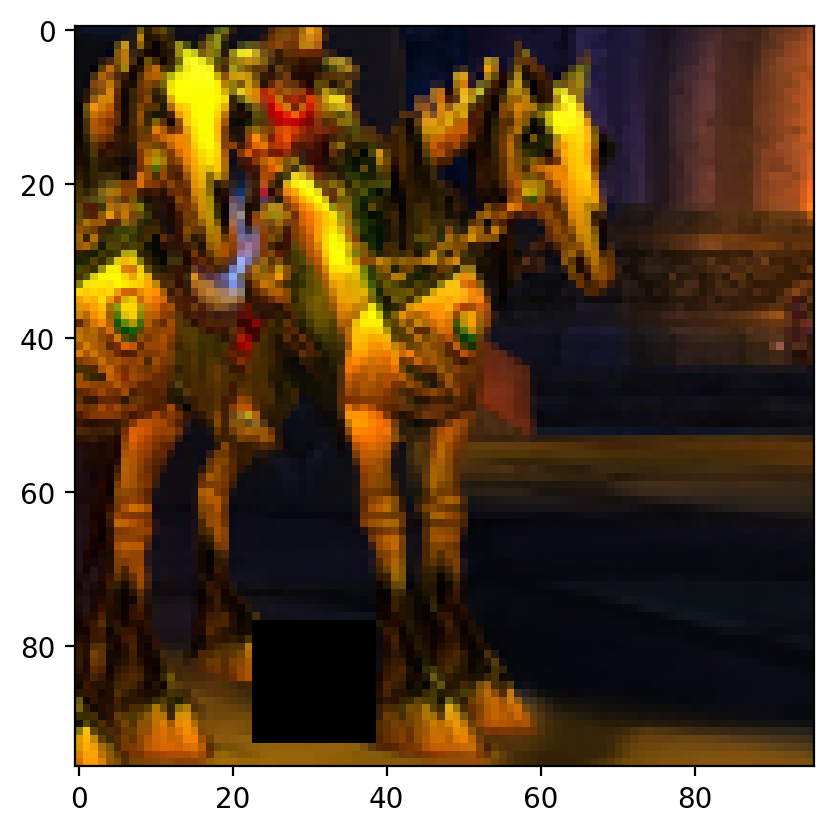

In [6]:
for i in range(len(trainset)):

  img, label_class = trainset.__getitem__(i)

  if label_class == 1:

    print('IMG shape: ', img.shape)
    img_show(img)

    break


One we have defined the Dataset, we can define train and test dataloaders!

In [7]:
batch_size = 32
valid_size = 500

# Training partition
part_tr = torch.utils.data.random_split(trainset, [len(trainset)-valid_size, valid_size])[0]
# Use sampler for randomization
training_sampler = torch.utils.data.SubsetRandomSampler(range(len(part_tr)))
# Define the dataloader
trainloader = torch.utils.data.DataLoader(part_tr, batch_size=batch_size, sampler=training_sampler)

# Validation partition
part_val = torch.utils.data.random_split(trainset, [valid_size, len(trainset)-valid_size])[0]
# Use sampler for randomization
valid_sampler = torch.utils.data.SubsetRandomSampler(range(len(part_val)))
# Define the dataloader
validloader = torch.utils.data.DataLoader(part_val, batch_size=batch_size, sampler=valid_sampler)

# Test partition
# Use sampler for randomization
test_sampler = torch.utils.data.SubsetRandomSampler(range(len(testset)))
# Define the dataloader
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, sampler=test_sampler)

In [8]:
print('TRAIN: ', len(part_tr))
print('VALIDATION: ', len(part_val))
print('TEST: ', len(testset))

TRAIN:  4500
VALIDATION:  500
TEST:  8000


# PART II: Define the CBAM

***SPATIAL ATTENTION MODULE (SAM)***

<figure>
<center><img src="https://blog.paperspace.com/content/images/2020/05/Capture-2.PNG" width="70%"></center> 
</figure>

Spatial Attention Module (SAM) is comprised of a three-fold sequential operation.  

*   **Channel Pool**: the Input Tensor of dimensions `(c × h × w)` is decomposed to 2 channels, i.e. `(2 × h × w)`, where each of the 2 channels represent Max Pooling and Average Pooling across the channels.
*   **Convolution layer** which outputs a 1-channel feature map, i.e., the dimension of the output is `(1 × h × w)`. Thus, this convolution layer is a spatial dimension preserving convolution and uses padding to do the same. In code, the convolution is followed by a Batch Norm layer to normalize and scale the output of convolution. However, the authors have also provided an option to use ReLU activation function after the Convolution layer, but by default it only uses Convolution + Batch Norm.
*   **Sigmoid Activation layer**, which will map all the values to a range between 0 and 1. 

This Spatial Attention mask is then applied to all the feature maps in the input tensor using a simple element-wise product.

> **Exercise**: complete the following code.

In [9]:
# 1. Channel Pool
class ChannelPool(nn.Module):

    def forward(self, x):

        out = torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )
        
        return out

In [11]:
# 2. Convolution Layer (+ Batch Normalization + ReLU activation)

class BasicConv(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        
        super(BasicConv, self).__init__()

        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, dilation, groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):

        x = self.conv(x)

        if self.bn is not None:
            x = self.bn(x) 

        if self.relu is not None:
             x = self.relu(x)

        return x


In [12]:
# === SPATIAL ATTENTION MODULE (SAM) === #


class SpatialGate(nn.Module):

    def __init__(self):

        super(SpatialGate, self).__init__()

        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(
            2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False
        )

        # NOTE:
        # // -> Divides the number on its left by the number on its right, rounds down the answer, and returns a whole number.

    def forward(self, x):

        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # mask

        return x * scale

***CHANNEL ATTENTION MODULE (CAM)***

<figure>
<center><img src="https://blog.paperspace.com/content/images/2020/05/Capture-3.PNG" width="70%"></center> 
</figure>

The Channel Attention Module (CAM) is another sequential operation but a bit more complex than Spatial Attention Module (SAM). 

*  It first decomposes the input tensor into 2 subsequent vectors of dimensionality `(c × 1 × 1)`. One of these vectors is generated by **Global Average Pooling (GAP)** while the other vector is generated by **Global Max Pooling (GMP)**. 

    *   **Average Pooling**: aggregates spatial information, it has a smoothing effect.
    *   **Max Pooling**: it preserves much richer contextual information in the form of edges of the object within the image which thus leads to finer channel attention. It preserves natural edges of the objects more precisely.

*  This vector is passed to a **Multi Layer Perceptron (MLP)** network which has a bottleneck whose width or number of neurons is decided by the reduction ratio (r). The higher the reduction ratio, the fewer the number of neurons in the bottleneck and vice versa.

*   The output is the passed to a **Sigmoid activation layer** which then maps the values within the range of 0 and 1.

> **Exercise**: complete the following code.


In [13]:
# AUXILIAR MODULE

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [14]:
# === CHANNEL ATTENTION MODULE (CAM) === #


class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16):

        super(ChannelGate, self).__init__()

        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels),
        )

    def forward(self, x):

        avg_pool = F.avg_pool2d(
            x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3))
        )
        channel_att_avg = self.mlp(avg_pool)

        max_pool = F.max_pool2d(
            x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3))
        )
        channel_att_max = self.mlp(max_pool)

        channel_att = channel_att_avg + channel_att_max

        scale = (
            channel_att.unsqueeze(2).unsqueeze(3).expand_as(x)
        )  # mask for the three channels

        return x * scale

***COMPLETE CBAM!***
> **Exercise**: complete the following code.

In [15]:
# === CONVOLUTIONAL BLOCK ATTENTION MODULE (CBAM) === #


class CBAM(nn.Module):

    def __init__(self, gate_channels, reduction_ratio=16, no_spatial=False):
        super(CBAM, self).__init__()

        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio)
        self.no_spatial = no_spatial

        if not no_spatial:
            self.SpatialGate = SpatialGate()

    def forward(self, x):

        x_out = self.ChannelGate(x)

        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)

        return x_out

**CBAM** is applied as a layer in every convolutional block of a convolutional neural network model. It takes in a tensor containing the feature maps from the previous convolutional layer and first refines it by applying channel attention using **CAM**. Subsequently this refined tensor is passed to **SAM** where the spatial attention is applied, thus resulting in the output refined feature maps. 

Now let's define a simple network including CBAM.

> **Exercise**: complete the following code.

In [16]:
# Convolutional block
class ConvPart(nn.Module):

    def __init__(self):

        super().__init__()

        # Convolution and Max Pooling
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)

        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.pool2(out)

        out = self.conv3(out)

        return out

In [17]:
# Full network including CBAM
class NetCBAM(nn.Module):

    def __init__(self, gate_channels=32):

        super().__init__()

        self.gate_channels = gate_channels

        # NN Blocks
        self.conv = ConvPart()
        self.attn1 = CBAM(gate_channels)
        self.linear = nn.Linear(self.gate_channels, 1)

    def forward(self, x):

        out_conv = self.conv(x)
        out_attn = self.attn1(out_conv)
        out = out_attn.mean(3).mean(2)
        out = self.linear(out)
        out = torch.sigmoid(out)[:, 0]

        return out, out_attn

The following class completes the implementation of our network, extending it with a training method.

> **Exercise**: complete the following code.

In [18]:
class NetCBAM_extended(NetCBAM):

    def __init__(self, gate_channels=32, lr=1e-3, epochs=20):

        super().__init__(gate_channels)

        # TRAINING VARIABLES
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        # CRITERION
        self.criterion = nn.BCELoss()

        # LOSS EVOLUTION
        self.loss_during_training = []
        self.valid_loss_during_training = []

        # GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self, trainloader, validloader):

        self.train()

        for e in range(int(self.epochs)):

            running_loss = 0.0

            for images, labels in trainloader:

                images = images.to(self.device)
                labels = labels.to(self.device)

                self.optim.zero_grad()

                pred, _ = self(images)

                loss = self.criterion(pred, labels)

                loss.backward()

                self.optim.step()

                running_loss += loss.item()

            self.loss_during_training.append(running_loss / len(trainloader))

            # Validation
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():

                running_loss = 0.0

                for images, labels in validloader:

                    images = images.to(self.device)
                    labels = labels.to(self.device)

                    pred, _ = self(images)

                    loss = self.criterion(pred, labels)

                    running_loss += loss.item()

                self.valid_loss_during_training.append(running_loss / len(validloader))

            print(
                "\nTrain Epoch: {} -> Training Loss: {:.6f}".format(
                    e, self.loss_during_training[-1]
                )
            )
            print(
                "Train Epoch: {} -> Validation Loss: {:.6f}".format(
                    e, self.valid_loss_during_training[-1]
                )
            )

    def eval_performance(self, dataloader):

        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)
                probs, _ = self(images)

                labels_pred = torch.round(probs)
                equals = labels_pred == labels
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            return accuracy / len(dataloader)

> **Exercise**: Train the model for 30 epochs. Plot the evolution of train and validation losses. Is the network overfitting?


Train Epoch: 0 -> Training Loss: 0.241239
Train Epoch: 0 -> Validation Loss: 0.255744

Train Epoch: 1 -> Training Loss: 0.115459
Train Epoch: 1 -> Validation Loss: 0.042017

Train Epoch: 2 -> Training Loss: 0.075365
Train Epoch: 2 -> Validation Loss: 0.026937

Train Epoch: 3 -> Training Loss: 0.063301
Train Epoch: 3 -> Validation Loss: 0.024594

Train Epoch: 4 -> Training Loss: 0.044648
Train Epoch: 4 -> Validation Loss: 0.024628

Train Epoch: 5 -> Training Loss: 0.050364
Train Epoch: 5 -> Validation Loss: 0.051406

Train Epoch: 6 -> Training Loss: 0.055108
Train Epoch: 6 -> Validation Loss: 0.054117

Train Epoch: 7 -> Training Loss: 0.058470
Train Epoch: 7 -> Validation Loss: 0.039254

Train Epoch: 8 -> Training Loss: 0.055221
Train Epoch: 8 -> Validation Loss: 0.016994

Train Epoch: 9 -> Training Loss: 0.042554
Train Epoch: 9 -> Validation Loss: 0.020725

Train Epoch: 10 -> Training Loss: 0.072200
Train Epoch: 10 -> Validation Loss: 0.031971

Train Epoch: 11 -> Training Loss: 0.0423

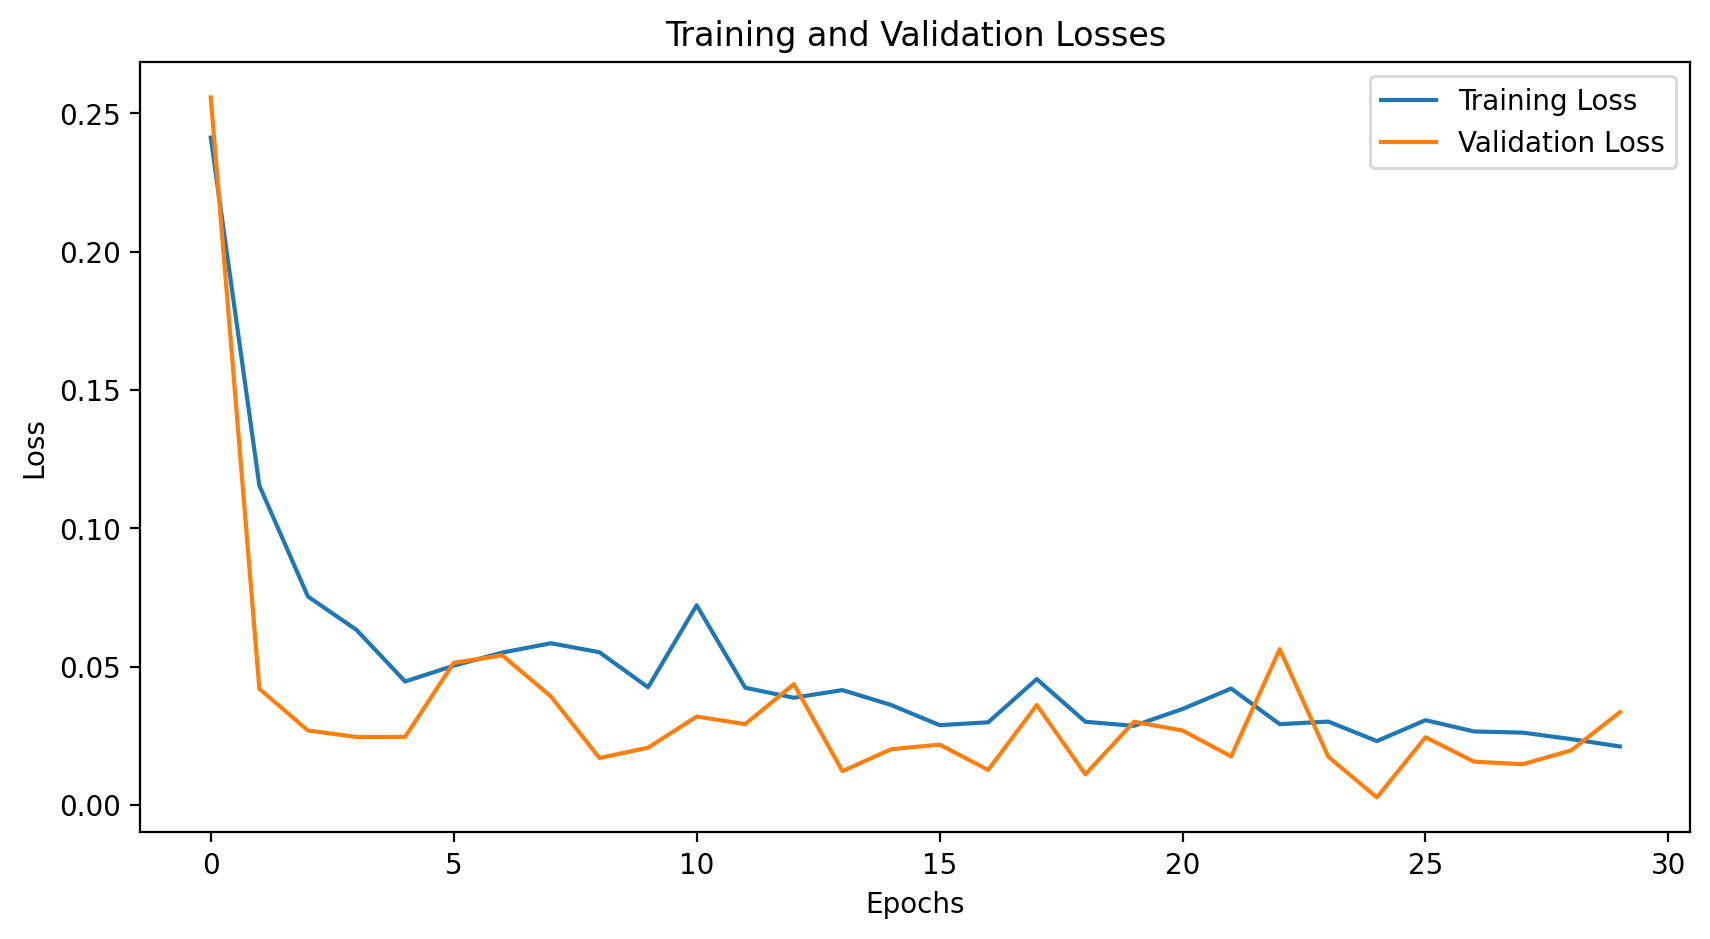

The network is overfitting.


In [19]:
model = NetCBAM_extended(gate_channels=32, lr=1e-3, epochs=30)

model.trainloop(trainloader, validloader)

plt.figure(figsize=(10, 5))
plt.plot(model.loss_during_training, label="Training Loss")
plt.plot(model.valid_loss_during_training, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Losses")
plt.show()

if model.valid_loss_during_training[-1] > model.loss_during_training[-1]:
    print("The network is overfitting.")
else:
    print("The network is not overfitting.")

> **Exercise**: Evaluate the performance of the model in the different data partitions.

In [20]:
# YOUR CODE HERE

train_accuracy = model.eval_performance(trainloader)
print(f"Training Accuracy: {train_accuracy:.4f}")

valid_accuracy = model.eval_performance(validloader)
print(f"Validation Accuracy: {valid_accuracy:.4f}")

test_accuracy = model.eval_performance(testloader)
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9872
Validation Accuracy: 0.9922
Test Accuracy: 0.9894


> **Exercise**: complete the following code to visualize some of the obtaines attention maps. Discuss the obtained results.

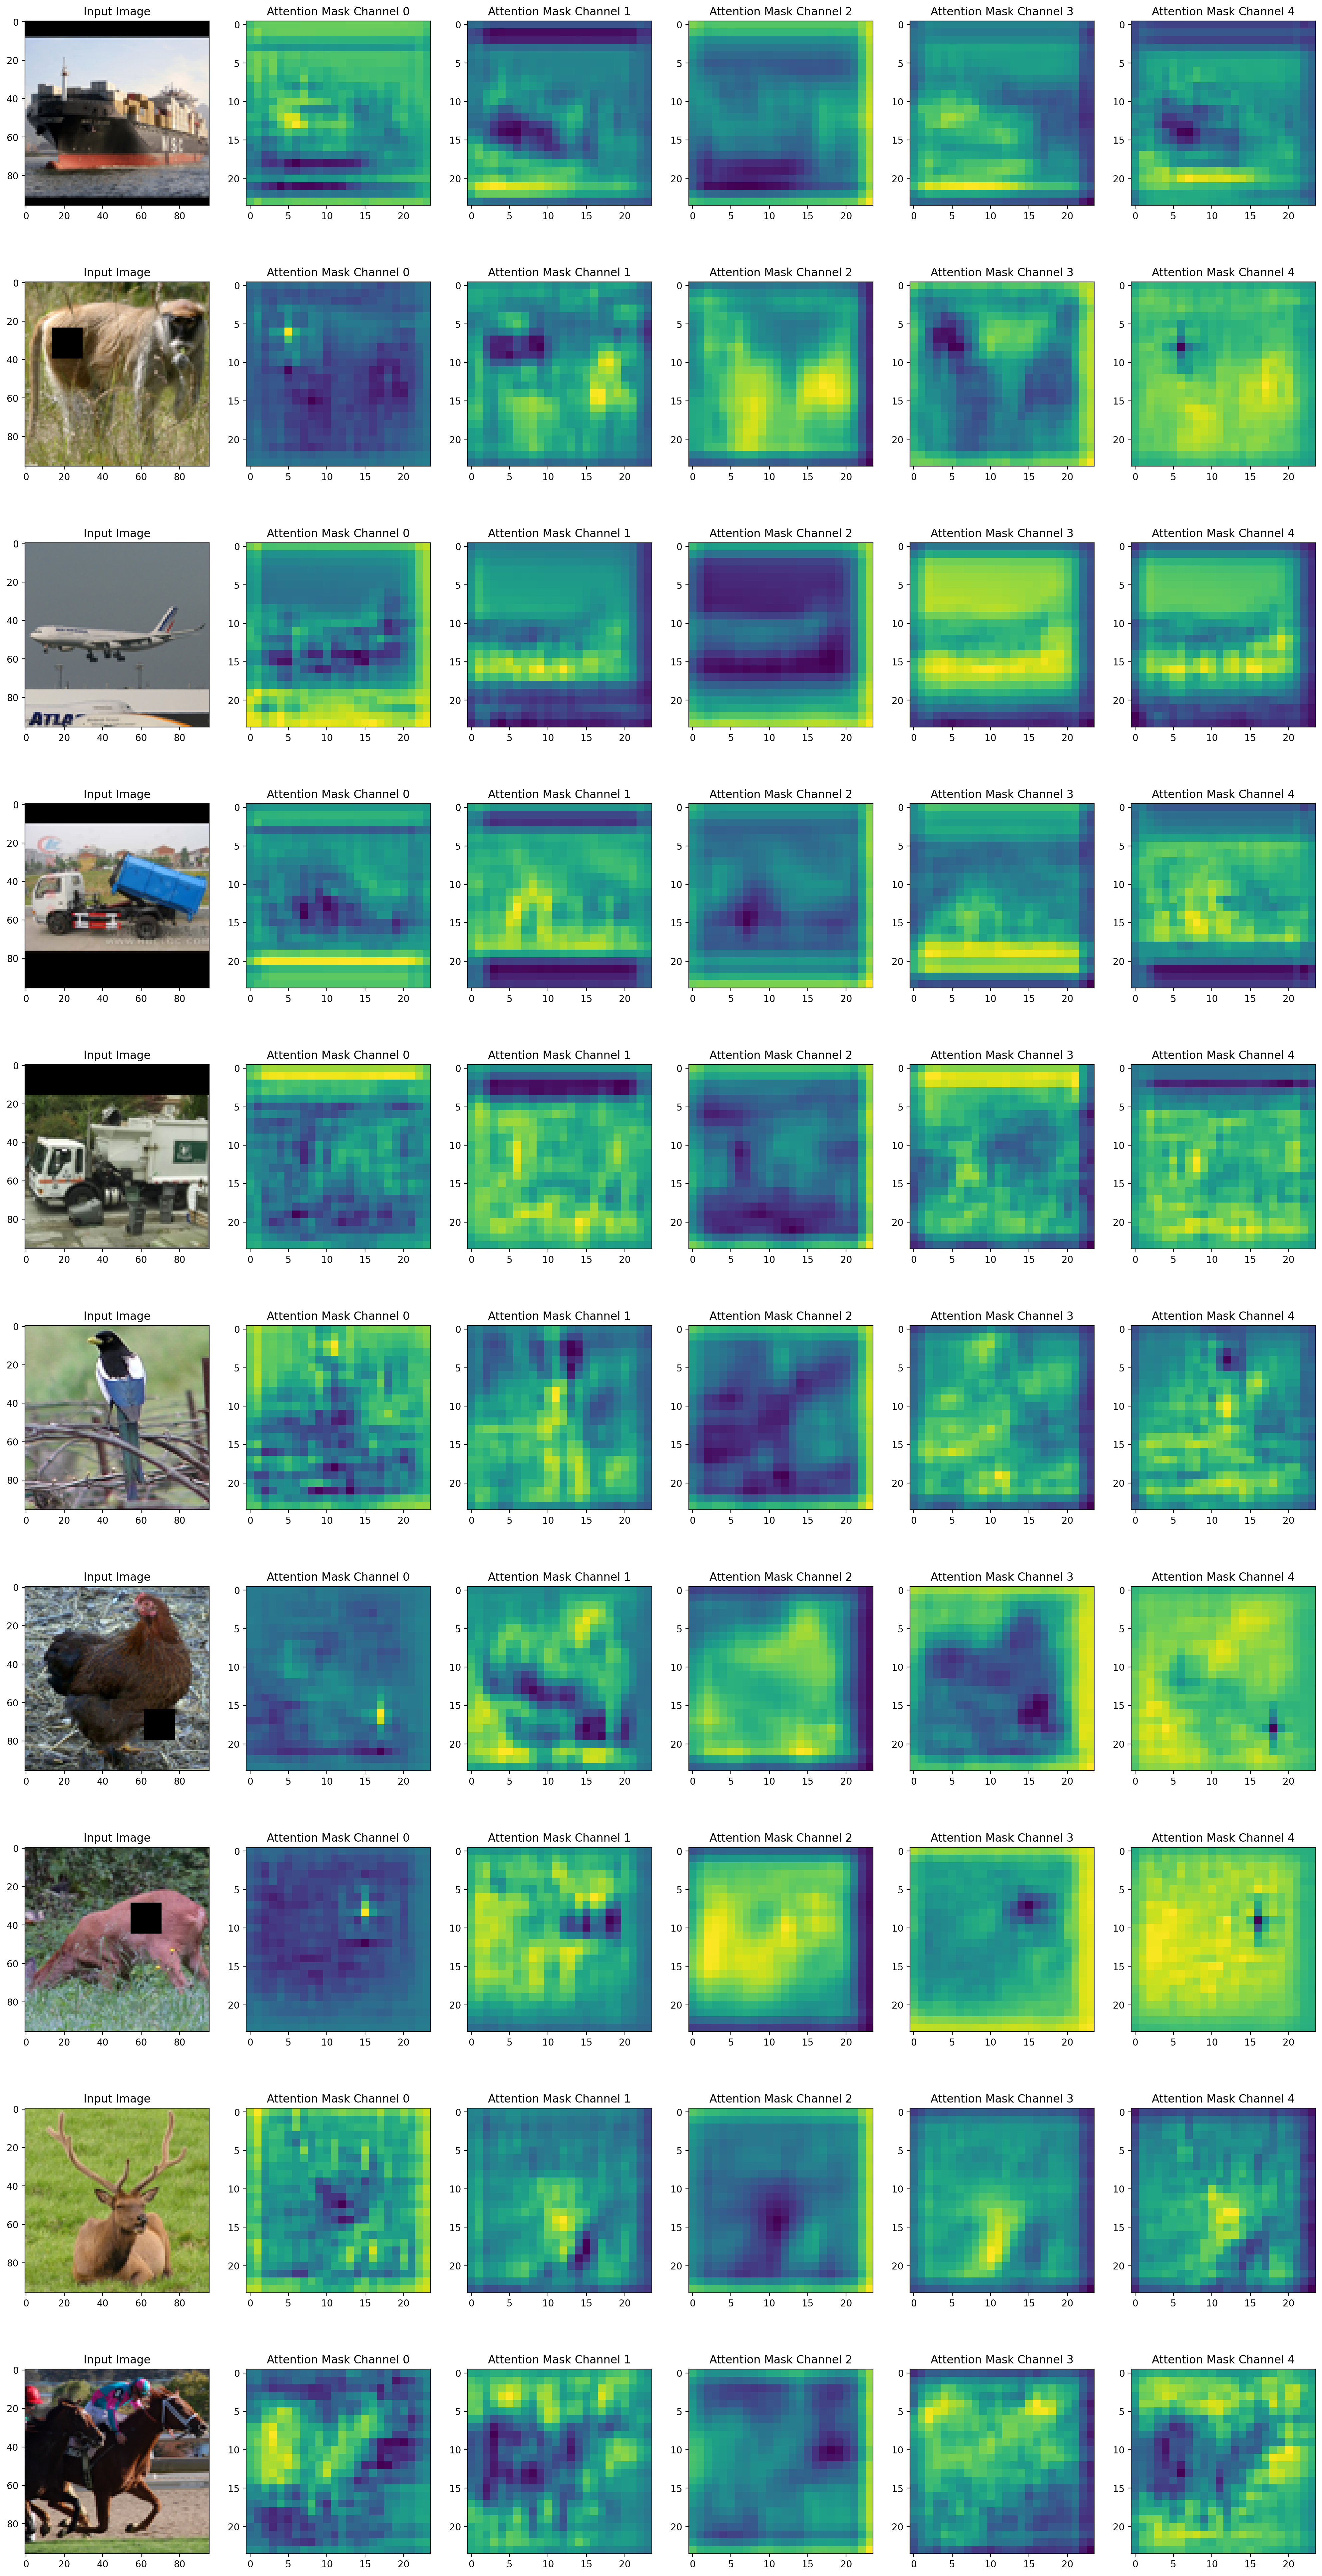

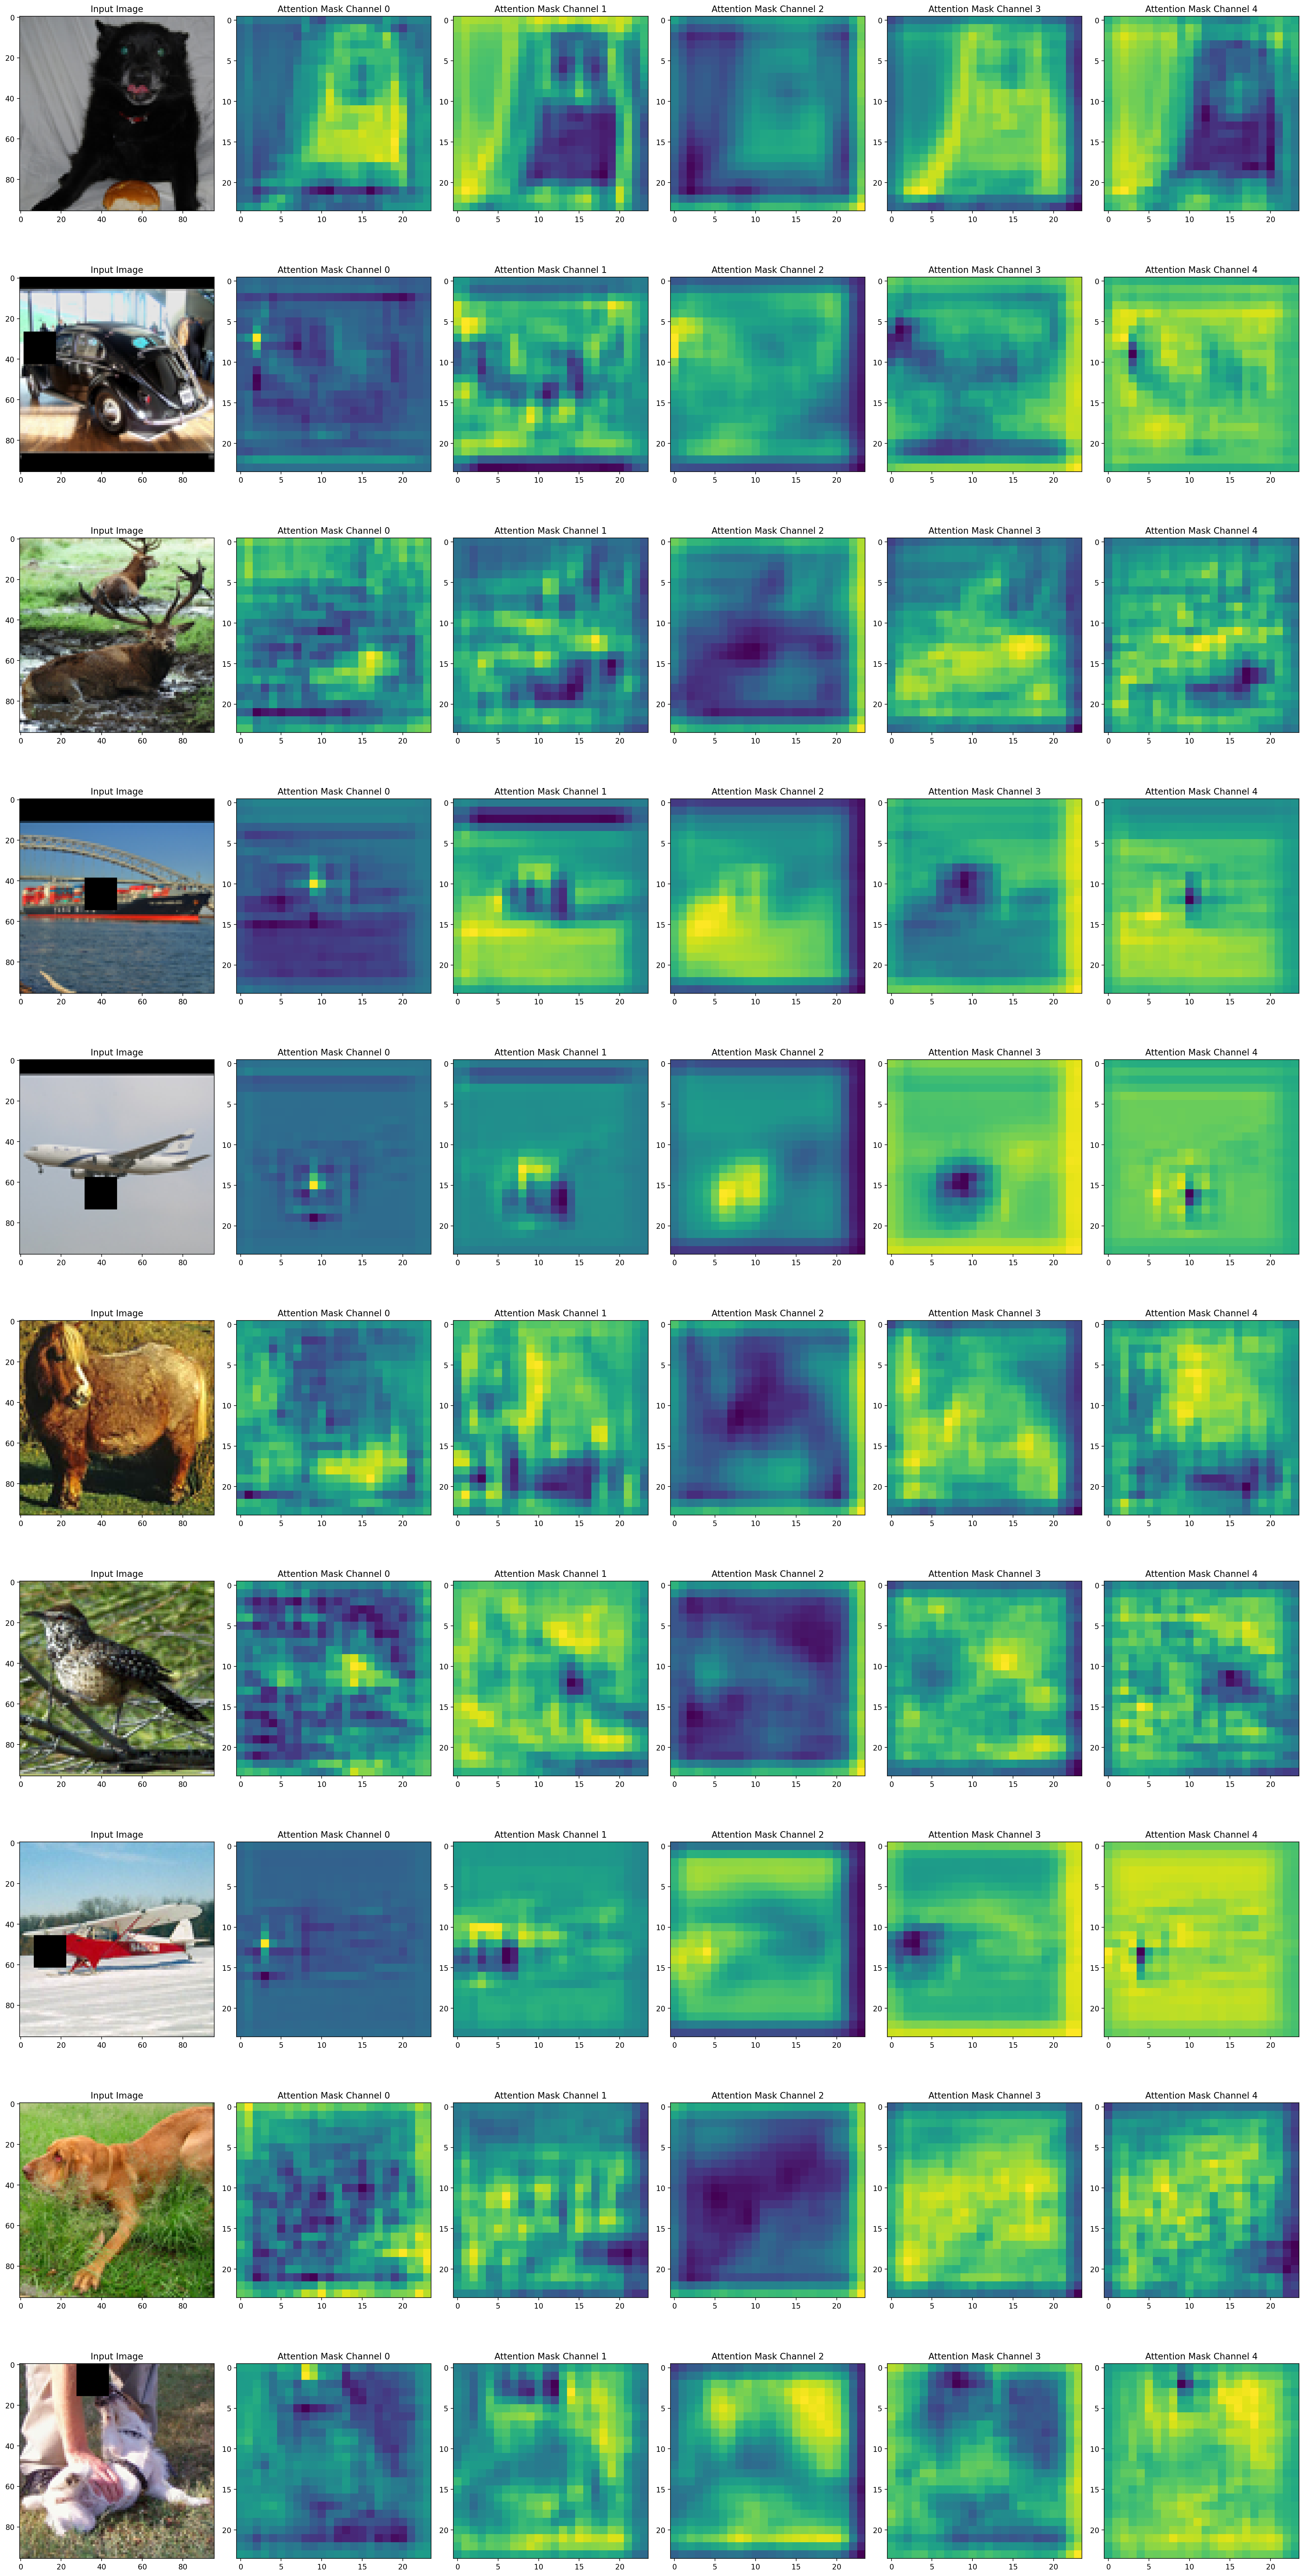

In [22]:
img, labels = next(iter(testloader))
img, labels = img.to(model.device), labels.to(model.device)

_, attn = model(img)

fig, axes = plt.subplots(10, 6, figsize=(5 * 5, 10 * 5))

for i in range(10):
    img_plot = np.transpose(img[i, :, :, :].cpu().detach().numpy(), (1, 2, 0))
    img_plot = img_plot / 2 + 0.5
    axes[i, 0].imshow(img_plot)
    axes[i, 0].set_title("Input Image")
    axes[i, 1].imshow(attn[i, 0, :, :].cpu().detach().numpy())
    axes[i, 1].set_title("Attention Mask Channel 0")
    axes[i, 2].imshow(attn[i, 1, :, :].cpu().detach().numpy())
    axes[i, 2].set_title("Attention Mask Channel 1")
    axes[i, 3].imshow(attn[i, 2, :, :].cpu().detach().numpy())
    axes[i, 3].set_title("Attention Mask Channel 2")
    axes[i, 4].imshow(attn[i, 3, :, :].cpu().detach().numpy())
    axes[i, 4].set_title("Attention Mask Channel 3")
    axes[i, 5].imshow(attn[i, 4, :, :].cpu().detach().numpy())
    axes[i, 5].set_title("Attention Mask Channel 4")

plt.tight_layout()
plt.show()

> **OPTIONAL EXERCISE**: compare the results obtained using the CBAM block with the ones obtained using a network that hasn't attention.